In [21]:
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
from torchvision import transforms
from tqdm import tqdm
from spikingjelly.activation_based import neuron, functional, surrogate , encoding , layer
import math
from numba.typed import List
import pyspike as spk
from numba import jit, prange, types

In [ ]:
# cython language_level=3




from numba import jit, prange, types
from numba.typed import List
import numpy as np


@jit(nopython=True)
def Interpolate(a, b, t):
    if t < a and a < b:  return a
    if t < b and b <= a: return b
    if t > b:            return b
    return t  # interpolation


@jit(nopython=True)
def get_tau(spikes1, spikes2, i, j, max_tau, MRTS):

    '''


    ## "distances" to neighbor: F/P=future/past, 1/2=N in spikesN.
    mF1 = max_tau
    mP1 = max_tau
    mF2 = max_tau
    mP2 = max_tau

    if i < len(spikes1) - 1 and i > -1:
        mF1 = (spikes1[i + 1] - spikes1[i])
    if j < len(spikes2) - 1 and j > -1:
        mF2 = (spikes2[j + 1] - spikes2[j])
    if i > 0:
        mP1 = (spikes1[i] - spikes1[i - 1])
    if j > 0:
        mP2 = (spikes2[j] - spikes2[j - 1])

    mF1, mF2, mP1, mP2 = mF1 / 2., mF2 / 2., mP1 / 2., mP2 / 2.
    MRTS /= 4.

    if i < 0 or j < 0 or spikes1[i] <= spikes2[j]:
        s1F = Interpolate(mP1, mF1, MRTS)
        s2P = Interpolate(mF2, mP2, MRTS)
        return min(s1F, s2P)
    else:
        s1P = Interpolate(mF1, mP1, MRTS)
        s2F = Interpolate(mP2, mF2, MRTS)
        return min(s1P, s2F)


    '''


    return 0.5




@jit(nopython=True)
def coincidence_single_profile_cython(spikes_times1, spikes_times2, t_start, t_end, max_tau, MRTS=0.):
    
    TotalRegularization = 0

    # spikes1 = ((torch.nonzero(spikestensor1)).view(1, -1)).numpy()[0]
    # spikes2 = ((torch.nonzero(spikestensor2)).view(1,-1)).numpy()[0]

    unsynchroned_times = []

    N1 = len(spikes_times1)
    N2 = len(spikes_times2)

    if N2 == 0:
        spikes_times2 = np.append(spikes_times2, np.array([10000000]))
        N2 = len(spikes_times2)

    j = -1
    c = np.zeros(N1)
    interval = t_end - t_start

    true_max = t_end - t_start
    if max_tau > 0:
        true_max = min(true_max, 2 * max_tau)

    for i in range(N1):

        tau1 = 0
        tau2 = 0

        while j < N2 - 1 and spikes_times2[j + 1] < spikes_times1[i]:
            # move forward until spikes2[j] is the last spike before spikes1[i]
            # note that if spikes2[j] is after spikes1[i] we dont do anything

            j += 1

        tau1 = get_tau(spikes_times1, spikes_times2, i, j, true_max, MRTS)

        if j > -1 and abs(spikes_times1[i] - spikes_times2[
            j]) < tau1:  # حداقل یه اسپایک جی گیر اوردیم و به علاوه یک شده در واقع یه اسپایک به جز اسپایک اول قبل اسپایکمون بوده
            c[i] = 1

        if j < N2 - 1 and (j < 0 or spikes_times2[j] < spikes_times1[i]):

            # in case spikes2[j] is before spikes1[i] it has to be the one
            # right before (see above), hence we move one forward and also
            # check the next spike

            j += 1

            tau2 = get_tau(spikes_times1, spikes_times2, i, j, true_max, MRTS)

            if abs(spikes_times2[j] - spikes_times1[i]) < tau2:
                # current spike in st1 is coincident

                c[i] = 1

        if c[i] == 0:

            # unsynchronized_spikes_data.append([spikes_times1[i] , tau1 , tau2])

            for t in range(int(spikes_times1[i] - tau1 + 1), int(spikes_times1[i] + tau2 + 1)):

                # times.append([t , unsynchronized_spikes_data[i][0] , unsynchronized_spikes_data[i][1] , unsynchronized_spikes_data[i][2]])
                # print(t , unsynchronized_spikes_data[i][0])

                if (t_start <= t <= t_end) and ((spikes_times1[i] > t and abs(spikes_times1[i] - t) < tau1) or (
                        spikes_times1[i] < t and abs(spikes_times1[i] - t) < tau2) or (spikes_times1[i] == t)):
                    unsynchroned_times.append(t)

    return unsynchroned_times  # , unsynchronized_spikes_data


In [23]:
## Download datasets
train_dataset = torchvision.datasets.MNIST(
    root = "'./data'",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

## DataLoaders
train_data_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size = 32,
    shuffle=True,
    drop_last=True,
    pin_memory=True
)

test_data_loader = data.DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    pin_memory=True
)

In [24]:
def regularization(spikestensor2, unsynchroned_times):


    if len(unsynchroned_times) != 0:
        # Convert unsynchroned_times to a PyTorch tensor
        unsynchroned_indices = torch.tensor(unsynchroned_times, device=spikestensor2.device, dtype=torch.long)
        # Efficiently select the spikes based on unsynchroned_indices
        selected_spikes = spikestensor2[unsynchroned_indices]
        # Perform the calculation in a vectorized way
        total_regularization = torch.sum((1 - selected_spikes) ** 2)
        # Get elements in A except the elements at indexes in b
        return total_regularization

    else:

        return 0

In [25]:
import pyspike as spk

def bach_unsychrony_loss(bach , group_size):

    loss = 0

    for image_index in range(bach.shape[0]) :

        image_tensor = bach[image_index]

        image_groups = torch.split(image_tensor , group_size , dim = 0)

        
        for selected_group in image_groups:



            if len(selected_group) > 1 :

                leader_spike = selected_group[0]
                spikes_times_leader = ((torch.nonzero(leader_spike)).view(1, -1)).cpu().numpy()[0]
                pyspike_spikes_times_leader = spk.SpikeTrain(spikes_times_leader , [0 , 100])
    
                for k in range(1, len(selected_group)):
                    
    
                    follower_spike_train = selected_group[k]
                    spikes_times_follower = ((torch.nonzero(follower_spike_train)).view(1,-1)).cpu().numpy()[0]
                    pyspike_spikes_times_follower = spk.SpikeTrain(spikes_times_follower , [0 , 100])
    
                    spike_profile = spk.spike_sync_profile(pyspike_spikes_times_leader , pyspike_spikes_times_follower)
                    spk_avg = spike_profile.avrg()
                        
                    unsychrony_times = coincidence_single_profile_cython(spikes_times_leader, spikes_times_follower, 0, 99, 3 , MRTS=0.)
                    loss = loss + regularization(follower_spike_train, unsychrony_times) + (1-spk_avg**2)*torch.sum(torch.pow(follower_spike_train , 2))


            else :

                continue
    

    return loss
                

    

In [26]:
for i in test_data_loader:
    print(np.shape(i[0]))
    break

torch.Size([32, 1, 28, 28])


In [27]:
class MyModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(MyModel, self).__init__()
        self.fc1 = layer.Linear(input_dim, 10) 
        self.lif1 = neuron.LIFNode(tau=2.0, surrogate_function=surrogate.ATan())
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.lif1(x)
        self.s_layer1 = x
        return x , self.s_layer1

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

0
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850


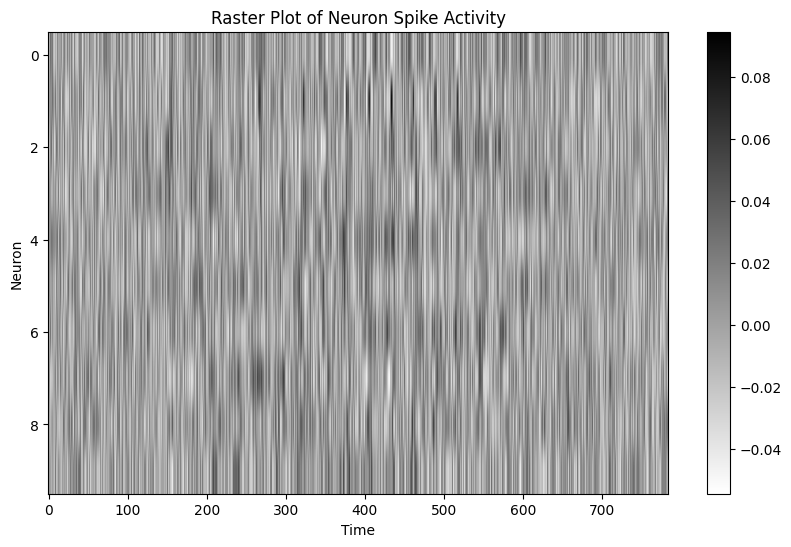

In [29]:
import torch
import matplotlib.pyplot as plt

Numberofspikes_synch = []
trainacc_synch = []
Synchloss_synch = []
last_epoch_record = []
Numberofspikes_normal = []
trainacc_normal = []
Synchloss = []
# Prepare the data
batch_size = 100
num_batches = 10
input_dim = 28*28 * 1
T= 100
encoder = encoding.PoissonEncoder()
epochs = 1
counter = 0

# Train the model
model = MyModel(input_dim).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(1):
    print(epoch)
    model.train()
    train_loss = 0
    train_acc = 0
    train_samples = 0
    synch_loss = 0
    number_of_spikes = 0
    for img, label in train_data_loader:
        optimizer.zero_grad()
        label_onehot = F.one_hot(label, 10).float()
        out_fr = 0
        if counter % 50 == 0:
            print(counter)
        counter +=1


        #bach_records = [] # array of shape [*NumberOfLayers[(tensors , ... of shape (batchImageNumbers*Time) which represent every neuron in layer)]]
        
        for t in range(T):
            
            encoded_img = encoder(img)

            # print(encoded_img.size())
            out , layers_spikes1  = model(encoded_img.to(device))
            #, layers_spikes2 , layers_spikes3 
            out_fr += out

            
            layers_spikes1 = layers_spikes1.unsqueeze(2)
            '''
            layers_spikes2 = layers_spikes2.unsqueeze(2)
            layers_spikes3 = layers_spikes3.unsqueeze(2)
            '''



            if t == 0 :

                slayer1 = layers_spikes1
                '''
                slayer2 = layers_spikes2
                slayer3 = layers_spikes3
                '''

            else :

                slayer1 = torch.cat((slayer1, layers_spikes1), dim=2)
                '''
                slayer2 = torch.cat((slayer2, layers_spikes2), dim=2)
                slayer3 =  torch.cat((slayer3, layers_spikes3), dim=2)
                '''

                
            

        # if epoch == epochs - 1:

        #     last_epoch_record.append(slayer1)
        
        number_of_spikes += torch.sum(slayer1).item()
        out_fr = out_fr/T
        loss_synch_layer1 = bach_unsychrony_loss(slayer1 , 3)


        
        loss = F.mse_loss(out_fr.to(device), label_onehot.to(device)) + (2*10**-7)*loss_synch_layer1
        loss.backward(retain_graph=True)
        optimizer.step()


        synch_loss += loss_synch_layer1.item()


        
        train_samples += label.numel() # number of elemets
        train_loss += loss.item()*label.numel()
        # The correct rate is calculated as follows:
        # The subscript i of the neuron with the highest firing rate in the output layer
        # is considered as the result of classification.
        train_acc += (out_fr.argmax(1)==label.to(device)).float().sum().item()

        # After optimizing the parameters, the state of the network should be reset
        # because the neurons of the SNN have “memory”.
        functional.reset_net(model)

# Visualize the raster plot
spike_activity = model.fc1.weight.detach().cpu().numpy()
plt.figure(figsize=(10, 6))
plt.imshow(spike_activity, cmap='binary', aspect='auto')
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.title('Raster Plot of Neuron Spike Activity')
plt.colorbar()
plt.show()